In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install pymorphy2 nltk

     |████████████████████████████████| 55 kB 2.6 MB/s 
     |████████████████████████████████| 8.2 MB 38.5 MB/s 


In [ ]:
!pip install gensim

In [ ]:
!pip install xgboost

In [19]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pymorphy2
import re
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
import seaborn as sns
import pylab

In [6]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
dir = '/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/d06/'

# Задание 1
1. Проведите предобработку текстов из файлов positive.csv, negative.csv. Нужно выполнить те же действия, что в предыдущем дне, но не удалять редко встречающиеся слова. Регулировать использование редких слов будем на уровне модели word2vec. Не забудьте удалить стоп-слова.
2. Будем исследовать то, как влияют на качество преобразования *размер целевого векторного пространства* и *использование редких слов*. Создайте несколько моделей word2vec, перебрав параметры:
  - размер результирующего пространства: [10, 300, 500] при фиксированной минимальной встречаемости слов = 10
  - минимальная встречаемость слов: [1, 10, 100] при фиксированном размере результирующего векторного пространства = 300

  Обучите их на всем пространстве текстов.

3. Отберите 5 случайных слов из выборки позитивных публикаций и 5 случайных слови из выборки негативных публикаций.
4. Для каждой из обученных моделей найдите по 15 синонимов и по 15 антонимов для каждого из слов из п.3. Опишите:
  - как влияет размер результирующего пространства на точность определения синонимов/антонимов моделью? почему?
  - как влияет минимальная встречаемость слов на точность определения синонимов/антонимов моделью? почему?
5. Постройте графики распределения слов в двумерном пространстве. Опишите, как влияют исследуемые параметры на кучность и расположение точек на графике. Почему?
6. Возьмите любой твит, обучите модель word2vec с параметрами по умолчанию и попробуйте предсказать продолжение твита. Также попробуйте предсказать продолжение случайной фразы. Сравните результаты, полученные после обучения моделей с разным количеством эпох обучения.

Подготовим набор данных из negative.csv и positive.csv

In [9]:
d_sample = pd.read_excel(dir + 'tweets_example.xlsx')
positive = pd.read_csv(dir + 'positive.csv', names=d_sample.columns, sep=';')
negative = pd.read_csv(dir + 'negative.csv', names=d_sample.columns, sep=';')
negative.loc[:, 'positive'] = 0
data = pd.concat([positive, negative], axis=0, ignore_index=True)
data

,id,date,name,text,positive,rep,rtv,fav,total_count,fol,friends,list_count
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1
...,...,...,...,...,...,...,...,...,...,...,...,...
226829,425138243257253888,1390195830,Yanch_96,Но не каждый хочет что то исправлять:( http://...,0,0,0,0,1138,32,46,0
226830,425138339503943682,1390195853,tkit_on,скучаю так :-( только @taaannyaaa вправляет мо...,0,0,0,0,4822,38,32,0
226831,425138437684215808,1390195876,ckooker1,"Вот и в школу, в говно это идти уже надо(",0,0,0,1,165,13,16,0
226832,425138490452344832,1390195889,LisaBeroud,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",0,0,1,0,2516,187,265,0


In [10]:
morph = pymorphy2.MorphAnalyzer()

def text_preprocessing(text):
    text = text.lower()
    text = re.sub(r"[^А-Яа-я]", " ", text)
    words = word_tokenize(text)
    words = [morph.parse(word)[0].normal_form for word in words]
    words = [word for word in words if word not in stopwords.words("russian")]
    return words

preprocessed_df = data[['text', 'positive']]
preprocessed_df.loc[:, 'text'] = data['text'].apply(text_preprocessing)

In [ ]:
preprocessed_df.head()

,text,positive
0,"[школотый, поверь, самый, общество, профилиров...",1
1,"[всё, таки, немного, похожий, мальчик, всё, ра...",1
2,"[идиотка, испугаться]",1
3,"[угол, сидеть, погибать, голод, ещ, порция, вз...",1
4,"[значит, страшилка, блин, посмотреть, всё, час...",1


In [ ]:
w2v_fixed_frequence = {s : Word2Vec(size=s, min_count=10) for s in [10, 300, 500]}
for model in w2v_fixed_frequence.values():
  model.build_vocab(preprocessed_df.text)

w2v_fixed_size = {c : Word2Vec(size=300, min_count=c) for c in [1, 10, 100]}
for model in w2v_fixed_size.values():
  model.build_vocab(preprocessed_df.text)

In [ ]:
np.random.seed(4)

positive_randoms = [np.random.choice(np.random.choice(preprocessed_df[preprocessed_df['positive'] == 1]['text'])) for i in range(5)]
negative_randoms = [np.random.choice(np.random.choice(preprocessed_df[preprocessed_df['positive'] == 0]['text'])) for i in range(5)]

In [ ]:
positive_randoms

['хд', 'поднять', 'хотеть', 'похоже', 'плюс']

In [ ]:
negative_randoms

['издеваться', 'ужасно', 'задание', 'песня', 'скучать']

In [ ]:
for size in w2v_fixed_frequence:
  print('-'*200)
  print(f"Fixed frequence = 10, Size = {size}")
  for i in range(5):
    synonyms_p = w2v_fixed_frequence[size].wv.most_similar(positive=[positive_randoms[i]], topn=15)
    antonyms_p = w2v_fixed_frequence[size].wv.most_similar(negative=[positive_randoms[i]], topn=15)
    synonyms_n = w2v_fixed_frequence[size].wv.most_similar(positive=[negative_randoms[i]], topn=15)
    antonyms_n = w2v_fixed_frequence[size].wv.most_similar(negative=[negative_randoms[i]], topn=15)
    print("    Synonyms for positive word {:20}Antonyms for positive word {:20}Synonyms for negative word {:20}Antonyms for negative word {:20}".format(positive_randoms[i], positive_randoms[i], negative_randoms[i], negative_randoms[i]))
    for j in range(15):
      print("       {:.2%} {:40}{:.2%} {:40}{:.2%} {:40}{:.2%} {:40}".format(synonyms_p[j][1], synonyms_p[j][0], antonyms_p[j][1], antonyms_p[j][0], synonyms_n[j][1], synonyms_n[j][0], antonyms_n[j][1], antonyms_n[j][0]))

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Fixed frequence = 10, Size = 10
    Synonyms for positive word хд                  Antonyms for positive word хд                  Synonyms for negative word издеваться          Antonyms for negative word издеваться          
       93.11% панель                                  93.39% аваад                                   92.80% долбануть                               92.47% хотя                                    
       89.74% умываться                               92.24% влюблённость                            89.86% лёша                                    90.26% погода                                  
       85.02% дверь                                   87.43% лым                                     89.47% марихуана                               88.88% сткий                      

С ростом результирующего пространства для всех антонимов и синонимов пропорционально уменьшается вероятность. Похоже, что в обученной модели семантически все слова становятся дальше друг от друга. Без обучения или с низкой размерностью у всех слов большая вероятность быть синонимами рандомному слову. То есть чем больше размерность, тем больше признаков, по которым слова могут быть похожими или непохожими. Чем больше признаков для отбора, там ниже в целом вероятность для слов быть отобранными в качестве синонимов или антонимов

In [ ]:
for min_count in w2v_fixed_size:
  print('-'*200)
  print(f"Fixed size = 300, Min frequence = {min_count}")
  for i in range(5):
    synonyms_p = w2v_fixed_size[min_count].wv.most_similar(positive=[positive_randoms[i]], topn=15)
    antonyms_p = w2v_fixed_size[min_count].wv.most_similar(negative=[positive_randoms[i]], topn=15)
    synonyms_n = w2v_fixed_size[min_count].wv.most_similar(positive=[negative_randoms[i]], topn=15)
    antonyms_n = w2v_fixed_size[min_count].wv.most_similar(negative=[negative_randoms[i]], topn=15)
    print("    Synonyms for positive word {:20}Antonyms for positive word {:20}Synonyms for negative word {:20}Antonyms for negative word {:20}".format(positive_randoms[i], positive_randoms[i], negative_randoms[i], negative_randoms[i]))
    for j in range(15):
      print("       {:.2%} {:40}{:.2%} {:40}{:.2%} {:40}{:.2%} {:40}".format(synonyms_p[j][1], synonyms_p[j][0], antonyms_p[j][1], antonyms_p[j][0], synonyms_n[j][1], synonyms_n[j][0], antonyms_n[j][1], antonyms_n[j][0]))

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Fixed size = 300, Min frequence = 1
    Synonyms for positive word хд                  Antonyms for positive word хд                  Synonyms for negative word издеваться          Antonyms for negative word издеваться          
       25.09% урурушенек                              24.03% соответствовать                         27.24% диктат                                  23.73% глуповато                               
       24.97% ушаков                                  23.95% параллельный                            25.05% искаться                                22.87% недостаток                              
       23.82% горшочек                                23.32% казловский                              22.66% школеий                                 22.74% неприкрытый            

При увеличении минимального количества встречаемости вероятности для слов падают. Это можно объяснить тем, что удаляются редкие слова, которые семантически были ближе к оставшимся. Остается лишь основной набор частоиспользуемых слов, которые формируют основной словарный запас. Логично предположить (да и из графика видно), что в основном словарном запасе слова будут располагаться довольно далеко друг от друга, чтобы за минимальное количество слов покрыть наибольшие сферы интереса (такая вот оптимизация). А чем больше расстояние между словами, тем меньше и вероятности им быть синонимами или антонимами

In [ ]:
def reduce_dimensions(w2v_model):
    tsne = TSNE(n_components=2, random_state=256)  # создадим экземпляр модели TSNE
    vectors = np.asarray(w2v_model.wv.vectors)     # возьмем из модели 300-мерный массив слов-векторов
    labels = np.asarray(w2v_model.wv.index2word)   # отдельно сохраним соответствие номера вектора и самого слова
    vectors = tsne.fit_transform(vectors)          # проведем преобразование каждого вектора в 2-мерный
    x = [v[0] for v in vectors]                    # запишем отдельно массив абсцисс и массив ординат
    y = [v[1] for v in vectors]
    return x, y, labels


def plot_w2v(w2v_model):
    x, y, labels = reduce_dimensions(w2v_model)                        # получим значения по осям и названия точек (исходные слова)
    plt.scatter(x, y)                                                  # строим график с точками
    words_to_show_indices = np.random.randint(len(labels), size=1000)  # выберем 1000 случайных слов, которые отобразим на графике
    for i in words_to_show_indices:
        plt.annotate(labels[i], (x[i], y[i]))                          # для каждого из этих 25 слов отобразим текст на картинке
    plt.show()

In [ ]:
pylab.rcParams['figure.figsize'] = (40, 40)

for size in [10, 300, 500]:
  plot_w2v(w2v_fixed_frequence[size])

Output hidden; open in https://colab.research.google.com to view.

С увеличением размерности растет количество признаков для сравнения слов. Слова более качественно семантически оцениваются. Слов, которые слишком далеко от всех слов, становится меньше, выявляются признаки, по которым они похожи на дальние слова. Распределение становится более равномерным и "кучным"

In [ ]:
for freq in [1, 10, 100]:
  plot_w2v(w2v_fixed_size[freq])

Output hidden; open in https://colab.research.google.com to view.

При очистке от редких слов удаляются слова, наиболее далекие от центра. На самом деле просто не хватало примеров, по которым можно было оценить их близость ко всем словам, поэтому они были близки только к одному или двум словам. Если взять слова, для которых есть огромное количество примеров употребления, для них проще получить более равномерное распределение, ведь они будут близки сразу многому количеству других слов, с которыми в паре они уже встречались

In [ ]:
np.random.seed(21)
random_tweet = np.random.choice(data['text'])
print(random_tweet)
random_tweet = text_preprocessing(random_tweet)[:-2]
print(random_tweet)

RT @qobevucolypa: А когда я был мелким, у меня была коллекция фишек со всеми покемонаме! 150 их вроде было =)
['мелкий', 'коллекция', 'фишка', 'весь']


In [ ]:
random_phrase = "Мы сегодня ходили в кино, купили карамельного попкорна. Показывали комедию, и мы очень много смеялись))"
random_phrase = text_preprocessing(random_phrase)[:-2]
print(random_phrase)

['сегодня', 'ходить', 'кино', 'купить', 'карамельный', 'попкорн', 'показывать', 'комедия']


In [ ]:
w2v_default = Word2Vec() #size=100, min_count=5
w2v_default.build_vocab(preprocessed_df.text)

In [ ]:
for e in range(10, 101, 10):
  w2v_default.train(preprocessed_df.text, total_examples=preprocessed_df.shape[0], epochs=e)
  tweet_output = w2v_default.predict_output_word(random_tweet, topn=10)
  phrase_output = w2v_default.predict_output_word(random_phrase, topn=10)
  print('-'*100)
  print(f"Default model, number of epoch = {e}")
  print("  {:40}{}".format("Output for random tweet:", "Output for random phrase:"))
  for i in range(10):
    print("    {:40}{}".format(f"{int(tweet_output[i][1]*10000)/100}% {tweet_output[i][0]}", f"{int(phrase_output[i][1]*10000)/100}% {phrase_output[i][0]}"))

----------------------------------------------------------------------------------------------------
Default model, number of epoch = 10
  Output for random tweet:                Output for random phrase:
    1.59% коллекция                         0.56% кино
    0.98% игрушка                           0.49% советовать
    0.57% собрать                           0.39% фильм
    0.19% попасться                         0.24% комедия
    0.18% фишка                             0.14% пивко
    0.18% киндёр                            0.14% кинотеатр
    0.16% чёрный                            0.14% хоббит
    0.16% левый                             0.1% мультик
    0.16% больший                           0.09% билет
    0.15% высота                            0.09% парка
----------------------------------------------------------------------------------------------------
Default model, number of epoch = 20
  Output for random tweet:                Output for random phrase:
    3.0% коллекция

In [ ]:
for e in [200, 400, 600]:
  w2v_default.train(preprocessed_df.text, total_examples=preprocessed_df.shape[0], epochs=e)
  tweet_output = w2v_default.predict_output_word(random_tweet, topn=10)
  phrase_output = w2v_default.predict_output_word(random_phrase, topn=10)
  print('-'*100)
  print(f"Default model, number of epoch = {e}")
  print("  {:40}{}".format("Output for random tweet:", "Output for random phrase:"))
  for i in range(10):
    print("    {:40}{}".format(f"{int(tweet_output[i][1]*10000)/100}% {tweet_output[i][0]}", f"{int(phrase_output[i][1]*10000)/100}% {phrase_output[i][0]}"))

----------------------------------------------------------------------------------------------------
Default model, number of epoch = 200
  Output for random tweet:                Output for random phrase:
    2.28% коллекция                         1.66% фильм
    0.72% яйцо                              1.49% кино
    0.64% игрушка                           0.68% понравиться
    0.56% монета                            0.67% комедия
    0.54% артур                             0.49% итог
    0.41% чехол                             0.42% околофутбол
    0.35% собирать                          0.37% хоббит
    0.33% пополниться                       0.35% советовать
    0.32% фишка                             0.34% мультик
    0.29% игра                              0.34% попкорн
----------------------------------------------------------------------------------------------------
Default model, number of epoch = 400
  Output for random tweet:                Output for random phrase:
    2.

Количество эпох не играет серьезной роли при обучении на больших наборах данных. Как можно заметить, результаты изменились и не везде в лучшую сторону. К фразе, связанной с кино в конечном итоге подобрался йогурт, хотя в моделях с 10ю эпохами его не было. При этом для предсказания рандомного твита все лишние слова отвалились. Фильм и кино, коллекция и игрушка все так же занимают лидирующие позиции.

Можно сказать, что модель переобучилась из-за большого количества эпох: на обучающей выборке результат стал лучше, а на тестовой (новая рандомная фраза) - ухудшился.

# Задание 2

В этом задании от вас требуется провести классификацию текстов с использованием градиентного бустинга. Постройте такую модель, которая даст наилучший результат по метрике precision к классу 0, подобрав гиперпараметры:
- минимальная встречаемость слова в текстах в doc2vec
- максимальная глубина деревеьев в бустинге
- количество деревьев в бустинге

Дайте ответ на вопрос: лучше использовать более глубокие или более мелкие деревья в модели градиентного бустинга?

In [11]:
tweets = [TaggedDocument(doc, [i]) for i, doc in enumerate(preprocessed_df.text)]       # преобразуем наши тексты в объекты, понятные док-2-веку
d2v_models = {c : Doc2Vec(tweets, min_count=c) for c in [1, 3, 10, 50]}                 # создадим модель Doc2Vec

for count in d2v_models:
  d2v_models[count].train(tweets, total_examples=len(tweets), epochs=20)                # подберем веса коэффициентов внутри модели, которые больше будут подходить к нашему набору текстов

In [12]:
X_train_texts, X_test_texts, y_train, y_test = train_test_split(preprocessed_df.text, preprocessed_df.positive, test_size=0.3, random_state=21)

In [13]:
def transform_text_array_to_vector_dataframe(text_array, model):
    columns = [str(n) for n in range(model.vector_size)]                                                        # задаем список названий колонок - просто порядковые номера
    vectors_ndarray = text_array.apply(model.infer_vector).to_list()                                            # прогоняем каждый текст через модель doc2vec и формируем многомерный массив чисел
    return pd.DataFrame(vectors_ndarray, columns=columns)                                                       # оборачиваем его в датафрейм для удобства

X_train = {c : transform_text_array_to_vector_dataframe(X_train_texts, d2v_models[c]) for c in [1, 3, 10, 50]}  # наконец создадим датафреймы, которые сможем подать в модель классификации
X_test = {c : transform_text_array_to_vector_dataframe(X_test_texts, d2v_models[c]) for c in [1, 3, 10, 50]}   

In [42]:
def compare_xgb_models_fixed_depth(c):
  xgb_fixed_depth = {e : XGBClassifier(max_depth=10, n_estimators=e) for e in [5, 10, 50, 250]}
  print("----------------- FIXED_DEPTH=10 MIN_COUNT={:2}-----------------".format(c))
  print()
  for e in [5, 10, 50, 250]:
    print("---------------------- N_ESTIMATORS={:3} ----------------------".format(e))
    xgb_fixed_depth[e].fit(X_train[c], y_train)
    y_pred = xgb_fixed_depth[e].predict(X_test[c])
    print(classification_report(y_pred, y_test))

In [43]:
for c in [1, 3, 10, 50]:
  compare_xgb_models_fixed_depth(c)
  print()

----------------- FIXED_DEPTH=10 MIN_COUNT= 1-----------------

---------------------- N_ESTIMATORS=  5 ----------------------
              precision    recall  f1-score   support

           0       0.60      0.57      0.58     34889
           1       0.57      0.59      0.58     33162

    accuracy                           0.58     68051
   macro avg       0.58      0.58      0.58     68051
weighted avg       0.58      0.58      0.58     68051

---------------------- N_ESTIMATORS= 10 ----------------------
              precision    recall  f1-score   support

           0       0.60      0.59      0.59     34365
           1       0.59      0.60      0.60     33686

    accuracy                           0.60     68051
   macro avg       0.60      0.60      0.60     68051
weighted avg       0.60      0.60      0.60     68051

---------------------- N_ESTIMATORS= 50 ----------------------
              precision    recall  f1-score   support

           0       0.62      0.62     

Количество деревьев влияет на четкость границы между классами. Теоретически, с ростом количества деревьев растет и точность модели, пока не найдется предельное количество деревьев, при котором рост точности становится незначительным. С учетом того, что скорость обучения пропорциональна количеству деревьев, переходить выше этого предельного количества не имеет смысла. Но определить границу при этом можно лишь на практике

В каждом из четырех рассмотренных случаев при изменении минимального количества слов в наборе, при котором данные слова попадают в модель, при росте числа деревьев точность модели росла. Какой-то четкой границы приращения полезности деревьев на четырех количествах увидеть тоже не получается. Слишком небольшой набор значений. Больший набор был бы слишком затратен по времени.

Так как между значениями 50 и 250 все еще наблюдается рост, попробуем запустить модель с гиперпараметром 500 деревьев и на этом остановимся. Если прирост будет значительным, выберем в качестве оптимального значения 500 деревьев. Если нет - 250

In [44]:
for c in [1, 3, 10, 50]:
  print("----------------- FIXED_DEPTH=10 MIN_COUNT={:2}-----------------".format(c))
  print()
  print("---------------------- N_ESTIMATORS=500 ----------------------")
  xgb_fixed_depth_1 = XGBClassifier(max_depth=10, n_estimators=500)
  xgb_fixed_depth_1.fit(X_train[c], y_train)
  y_pred = xgb_fixed_depth_1.predict(X_test[c])
  print(classification_report(y_pred, y_test))
  print()

----------------- FIXED_DEPTH=10 MIN_COUNT= 1-----------------

---------------------- N_ESTIMATORS=500 ----------------------
              precision    recall  f1-score   support

           0       0.63      0.64      0.63     32841
           1       0.66      0.65      0.65     35210

    accuracy                           0.64     68051
   macro avg       0.64      0.64      0.64     68051
weighted avg       0.64      0.64      0.64     68051


----------------- FIXED_DEPTH=10 MIN_COUNT= 3-----------------

---------------------- N_ESTIMATORS=500 ----------------------
              precision    recall  f1-score   support

           0       0.64      0.65      0.64     32713
           1       0.67      0.65      0.66     35338

    accuracy                           0.65     68051
   macro avg       0.65      0.65      0.65     68051
weighted avg       0.65      0.65      0.65     68051


----------------- FIXED_DEPTH=10 MIN_COUNT=10-----------------

---------------------- N_E

In [14]:
estim_results = pd.DataFrame({'min_count_1' : [0.60, 0.60, 0.62, 0.63, 0.63], 'min_count_3' : [0.59, 0.61, 0.63, 0.64, 0.64], 'min_count_10' : [0.59, 0.60, 0.62, 0.64, 0.64], 'min_count_50' : [0.58, 0.59, 0.62, 0.64, 0.64]}, index=[5, 10, 50, 250, 500])
estim_results

,min_count_1,min_count_3,min_count_10,min_count_50
5,0.60,0.59,0.59,0.58
10,0.60,0.61,0.60,0.59
50,0.62,0.63,0.62,0.62
250,0.63,0.64,0.64,0.64
500,0.63,0.64,0.64,0.64


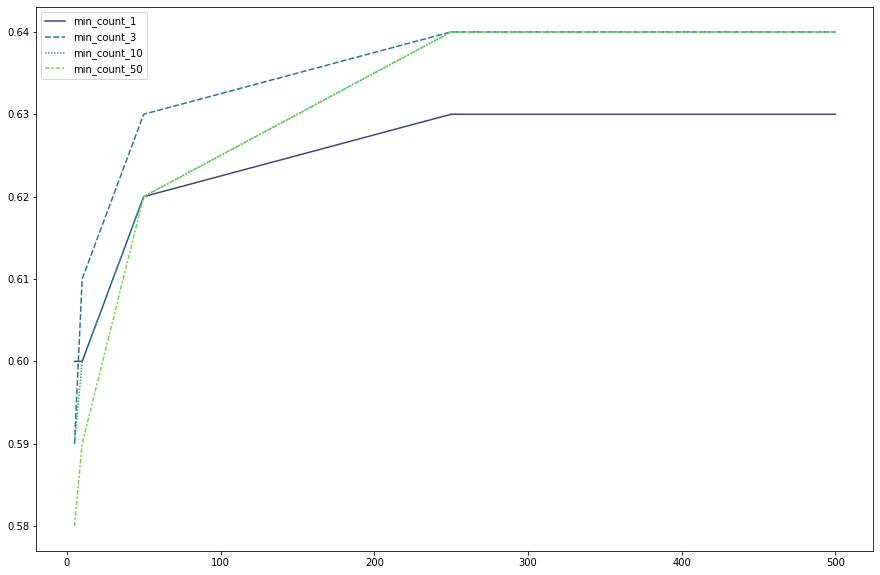

In [23]:
pylab.rcParams['figure.figsize'] = (15, 10)
sns.lineplot(data=estim_results, palette='viridis')
plt.show()

250 деревьев оказалось достаточно

In [27]:
def compare_xgb_models_fixed_estim(c):
  xgb_fixed_estim = {d : XGBClassifier(max_depth=d, n_estimators=50) for d in [3, 6, 12, 24]}
  print("----------------- FIXED_ESTIM=50 MIN_COUNT={:2}-----------------".format(c))
  print()
  for d in [3, 6, 12, 24]:
    print("------------------------ MAX_DEPTH={:3} ------------------------".format(d))
    xgb_fixed_estim[d].fit(X_train[c], y_train)
    y_pred = xgb_fixed_estim[d].predict(X_test[c])
    print(classification_report(y_pred, y_test))

In [28]:
for c in [1, 3, 10, 50]:
  compare_xgb_models_fixed_estim(c)
  print()

----------------- FIXED_ESTIM=50 MIN_COUNT= 1-----------------

------------------------ MAX_DEPTH=  3 ------------------------
              precision    recall  f1-score   support

           0       0.60      0.59      0.59     33914
           1       0.60      0.60      0.60     34137

    accuracy                           0.60     68051
   macro avg       0.60      0.60      0.60     68051
weighted avg       0.60      0.60      0.60     68051

------------------------ MAX_DEPTH=  6 ------------------------
              precision    recall  f1-score   support

           0       0.62      0.61      0.61     34052
           1       0.61      0.62      0.62     33999

    accuracy                           0.62     68051
   macro avg       0.62      0.62      0.62     68051
weighted avg       0.62      0.62      0.62     68051

------------------------ MAX_DEPTH= 12 ------------------------
              precision    recall  f1-score   support

           0       0.62      0.62  

In [29]:
depth_results = pd.DataFrame({'min_count_1' : [0.60, 0.62, 0.62, 0.62, 0.60], 'min_count_3' : [0.60, 0.62, 0.63, 0.61, 0.61], 'min_count_10' : [0.59, 0.62, 0.62, 0.62, 0.62], 'min_count_50' : [0.57, 0.61, 0.62, 0.62, 0.62]}, index=[3, 6, 10, 12, 24])
depth_results

,min_count_1,min_count_3,min_count_10,min_count_50
3,0.60,0.60,0.59,0.57
6,0.62,0.62,0.62,0.61
10,0.62,0.63,0.62,0.62
12,0.62,0.61,0.62,0.62
24,0.60,0.61,0.62,0.62


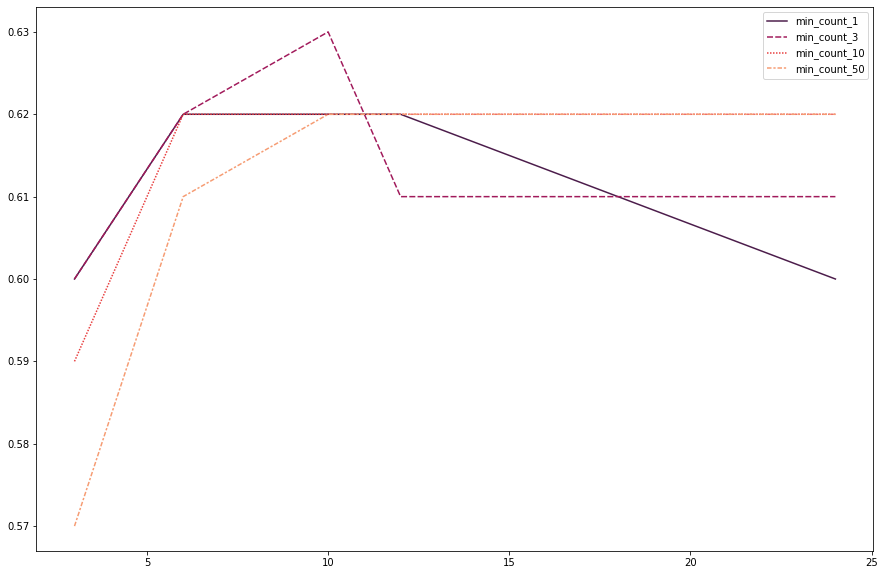

In [31]:
pylab.rcParams['figure.figsize'] = (15, 10)
sns.lineplot(data=depth_results, palette='rocket')
plt.show()

Модели с глубиной деревьев 10 показывают лучшую точность на классе 0 по метрике precision.

In [35]:
count_results_1 = pd.DataFrame({'estim_5' : [0.60, 0.59, 0.59, 0.58], 'estim_10' : [0.60, 0.61, 0.60, 0.59], 'estim_50' : [0.62, 0.63, 0.62, 0.62], 'estim_250' : [0.63, 0.64, 0.64, 0.64], 'estim_500' : [0.63, 0.64, 0.64, 0.64]}, index=[1, 3, 10, 50])
count_results_1

,estim_5,estim_10,estim_50,estim_250,estim_500
1,0.60,0.60,0.62,0.63,0.63
3,0.59,0.61,0.63,0.64,0.64
10,0.59,0.60,0.62,0.64,0.64
50,0.58,0.59,0.62,0.64,0.64


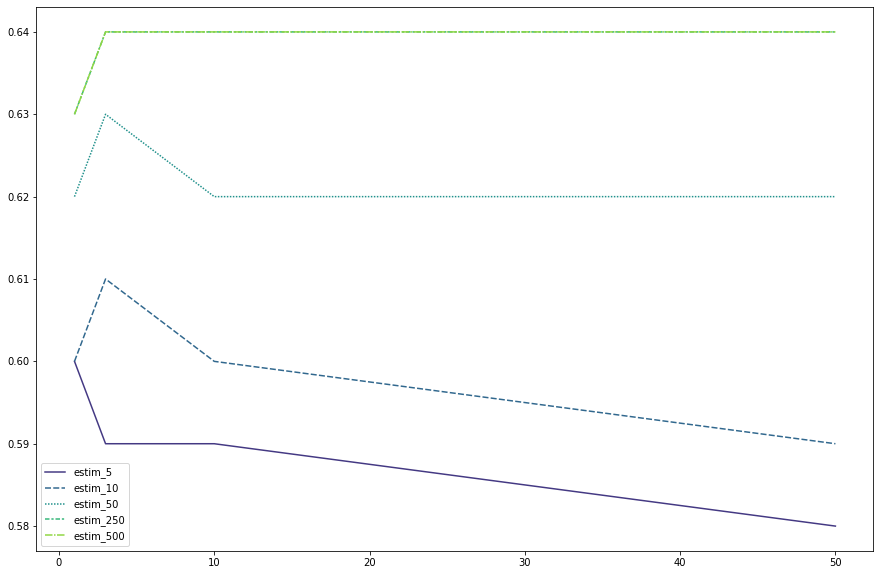

In [36]:
pylab.rcParams['figure.figsize'] = (15, 10)
sns.lineplot(data=count_results_1, palette='viridis')
plt.show()

In [33]:
count_results_2 = pd.DataFrame({'depth_3' : [0.60, 0.60, 0.59, 0.57], 'depth_6' : [0.62, 0.62, 0.62, 0.61], 'depth_10' : [0.62, 0.63, 0.62, 0.62], 'depth_12' : [0.62, 0.61, 0.62, 0.62], 'depth_24' : [0.60, 0.61, 0.62, 0.62]}, index=[1, 3, 10, 50])
count_results_2

,depth_3,depth_6,depth_10,depth_12,depth_24
1,0.60,0.62,0.62,0.62,0.60
3,0.60,0.62,0.63,0.61,0.61
10,0.59,0.62,0.62,0.62,0.62
50,0.57,0.61,0.62,0.62,0.62


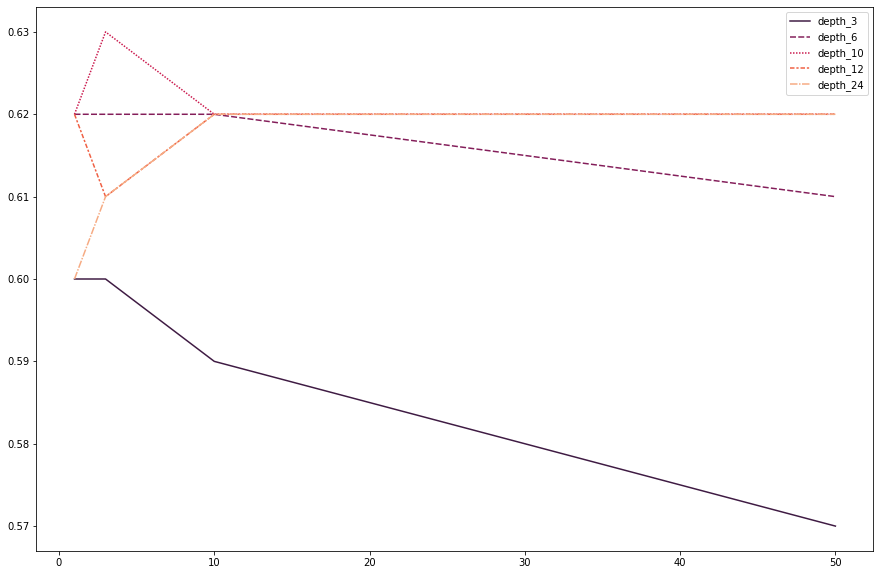

In [34]:
pylab.rcParams['figure.figsize'] = (15, 10)
sns.lineplot(data=count_results_2, palette='rocket')
plt.show()

Большинство моделей теряют точность при отбрасывании слов, встречающихся меньше 10 раз. Модель с параметрами 10-250 не теряет сточности но и не улучшает ее.

Выбираем модель градиентного бустинга со следующими параметрами:
- минимальное количество появлений слова в выборке = 3
- количество деревьев = 250
- глубина деревьев = 10

Итоговая точность модели : 0.64

В модели градиентного бустинга лучше использовать мелкие деревья потому что
1. Повышается обобщающая способность моделей
2. Уменьшается склонность к переобучению
3. Уменьшается время обучения модели
4. Все уменьшающие точность факторы исчезают, потому что будет построено множество деревьев с выбранными параметрами, и наибольший вклад будут вносить только самые полезные из них. Самые бесполезные и неточные не будут вносить весомого вклада